# Interpretting and Visualizing AutoCorelation. 

Analysing a Time Series Data needs special attention. Here we would like to explore more about working with a time series data and identify the effect of auto correlation and there by channelize our thoughts to come up with a more practical approach to work with time series. To prepare this article, we decided to pick a financial data set. finance is one domain where time series data is available easily but yet there is a lack of online resources to accurately come up with a model that is insightfull in predicting or giving insights on future. After a quick research we decided to work on Shiller PE ratio and predict the movement of S&P monthly closing price : http://www.multpl.com/shiller-pe/table?f=m

#### Domain Knowledge 

The cyclically adjusted price-to-earnings ratio, commonly known as CAPE, Shiller P/E, or P/E 10 ratio,is a valuation measure usually applied to the US S&P 500 equity market. It is defined as price divided by the average of ten years of earnings (moving average), adjusted for inflation. As such, it is principally used to assess likely future returns from equities over timescales of 10 to 20 years, with higher than average CAPE values implying lower than average long-term annual average returns.

#### Webscrapping 

We start with extracting data scrapping the shiller PE ratio and S&P closing prices from 
http://www.multpl.com/shiller-pe/table?f=m

## Data Extraction using Beautifull Soup library

We use request library to query the server and get the webpage as source object and then we use beautifull soup library to extract the table information from the webpage.

In [1]:
from requests import get
from bs4 import BeautifulSoup

url="http://www.multpl.com/shiller-pe/table?f=m"
source=get(url)
webpage_data=BeautifulSoup(source.text,"lxml")
data_table=webpage_data.find('table',id='datatable')
data_row=data_table.findAll('tr')
data_list=[]
for i in range(1,len(data_row)):
    each_row=data_row[i].text.split('\n')
    data_list.append([each_row[1],each_row[2]])

shiller_ratio_data=data_list.copy()
print("Output : Completed extracting Shiller Ratio")

    

Output : Completed extracting Shiller Ratio


Now we would also want the closing prices on each month this could be obtained from below url
http://www.multpl.com/s-p-500-historical-prices/table/by-month. So we can extract the table data in exactly similar method.

In [2]:
url="http://www.multpl.com/s-p-500-historical-prices/table/by-month"
source=get(url)
webpage_data=BeautifulSoup(source.text,"lxml")
data_table=webpage_data.find('table',id='datatable')
data_row=data_table.findAll('tr')
data_list=[]
for i in range(1,len(data_row)):
    each_row=data_row[i].text.split('\n')
    data_list.append([each_row[1],each_row[2]])
    
SandP_closing_data=data_list.copy()
print("Output : Completed extracting SandP Ratio")


Output : Completed extracting SandP Ratio


Now we have data extracted in two list. We create a pandas data frame with index column as time series and S&P closing and Shiller Ratio as our data columns. Pandas Data frame with a series of values in datetime format as index is often generally called a Time Series.

## Data Preparation and Data Cleaning using Pandas library : Creating a Time Series

In [3]:
import pandas as pd
import datetime

df_shiller=pd.DataFrame(shiller_ratio_data,columns=["sh_Date","sh_Ratio"])
df_SandP=pd.DataFrame(SandP_closing_data,columns=["SandP_Date","SandP_Closing_Price"])

So we have shiller ratio data and S&P closing price in two different dataframes, now lets perform a lookup function to get the shiller PE ratio for each month into the closing price data frame.

In [4]:
df_data=df_SandP.merge(df_shiller, left_on='SandP_Date',right_on='sh_Date', how='outer')
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1769 entries, 0 to 1768
Data columns (total 4 columns):
SandP_Date             1769 non-null object
SandP_Closing_Price    1769 non-null object
sh_Date                1649 non-null object
sh_Ratio               1649 non-null object
dtypes: object(4)
memory usage: 69.1+ KB


We have 1769 entries and 4 columns SandP_Date and sh_Date are date columns we could easily drop one of them and we need to check for null values.


In [5]:
df_data=df_data.drop('sh_Date',axis=1)
df_data.isnull().sum()

SandP_Date               0
SandP_Closing_Price      0
sh_Ratio               120
dtype: int64

sh_Ratio has 120 null values, we could drop these values from our dataset safely as this accounts to less than 6% of total row items

In [6]:
df_data=df_data.dropna()
df_data.head(5)

,SandP_Date,SandP_Closing_Price,sh_Ratio
0,"May 17, 2018","2,720.01",32.33
1,"Apr 1, 2018","2,633.45",31.30
2,"Mar 1, 2018","2,702.77",32.12
3,"Feb 1, 2018","2,705.16",32.15
4,"Jan 1, 2018","2,789.80",33.31


Now we create a time series for which the SandP Date column needs to formatted correctly so that we are able to assign the correct datatype for each columns.

In [7]:
df_data['SandP_Closing_Price']=df_data['SandP_Closing_Price'].str.replace(',','')
df_data['SandP_Date']=df_data['SandP_Date'].str.replace(',','')

df_data['SandP_Closing_Price']=df_data['SandP_Closing_Price'].astype('float64')
df_data['sh_Ratio']=df_data['sh_Ratio'].astype('float64')

df_data['SandP_Date'] =  pd.to_datetime(df_data['SandP_Date'], format='%b %d %Y')
df_data=df_data.set_index('SandP_Date')
df_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1649 entries, 2018-05-17 to 1881-01-01
Data columns (total 2 columns):
SandP_Closing_Price    1649 non-null float64
sh_Ratio               1649 non-null float64
dtypes: float64(2)
memory usage: 38.6 KB


Now our Dataframe is in a time series format and ready for further analysis.

## Time Series Analysis 

In [8]:
# so our data frame is now a time series object let us use the common notation ts for this data frame.
ts=df_data.copy()

### Time Series : Visualization

In [149]:
import matplotlib.pylab as plt

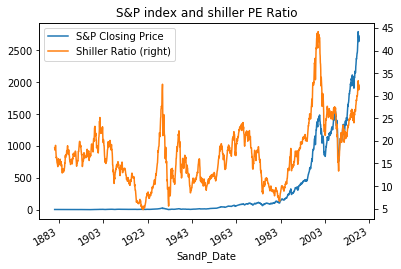

In [150]:
ts.SandP_Closing_Price.plot(label="S&P Closing Price", legend=True,title='S&P index and shiller PE Ratio')
ts.sh_Ratio.plot(secondary_y=True, label="Shiller Ratio", legend=True)

The above graph gives a picture of how the Sand P index performed over the years, along with Shiller PE ratio. Lets visualize the same over our training data and test data.

#### Visualizing subset of time series

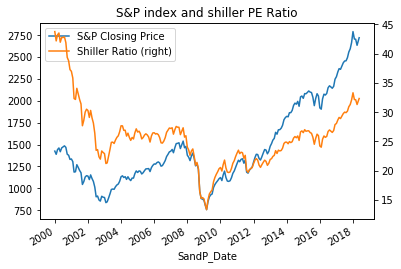

In [151]:
ts[:'2000'].SandP_Closing_Price.plot(label="S&P Closing Price", legend=True,title='S&P index and shiller PE Ratio')
ts[:'2000'].sh_Ratio.plot(secondary_y=True, label="Shiller Ratio", legend=True)

The graph provides the range of values shiller ratio and S&P closing price from 2005 to till date. The visualization clearly provides insights on the 2008-2009 financial crisis with a dip in the values ever since the S and P and shiller ratio both have been in an upward trend with minor dips in the way. 

Now let us split our dataset into x,y,training and test set. Since we have our dataframe in timeseries format we are able to split it by year.

#### Splitting Time Series to training and test data

In [152]:
x_train=ts['2010-01-01':'2001-01-01']['sh_Ratio']  # Column sh_Ratio of our time sereis (2010-2001) is taken as x train value and stored in x_train list
y_train=ts['2010-01-01':'2001-01-01']['SandP_Closing_Price']  # Column SandP_ Closing Price (2010-2001) of our time sereis is taken as y train value and stored in y_train list
x_test=ts['2012-01-01':'2010-01-01']['sh_Ratio']  # Column sh_Ratio (2012-2010) of our time sereis is taken as x test value and stored in x_test list
y_test=ts['2012-01-01':'2010-01-01']['SandP_Closing_Price'] # Column SandP_Closing Price  (2012-2010)of our time sereis is taken as y value and stored in y_test list

Now lets import essential libraries like stats model for preparing our OLS Linear regression model
we are using Stats model instead of sklearn because it has a bettter detailed output and one of the critical test score 'DURBIN-WATSON' is easily obtained from stats model OLS output.

#### Simple Linear Regression using OLS statsmodel

In [153]:
import statsmodels.api as sm

model=sm.OLS(y_train,x_train)
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     SandP_Closing_Price   R-squared:                       0.974
Model:                             OLS   Adj. R-squared:                  0.974
Method:                  Least Squares   F-statistic:                     4010.
Date:                 Fri, 18 May 2018   Prob (F-statistic):           3.18e-87
Time:                         14:39:35   Log-Likelihood:                -726.77
No. Observations:                  109   AIC:                             1456.
Df Residuals:                      108   BIC:                             1458.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sh_Ratio      45.7366      0.722     63.324      0.000      44.305      47.168
==============================================================================
Omnibus:                       61.272   Durbin-Watson:                   0.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.709
Skew:                          -0.078   Prob(JB):                       0.0212
Kurtosis:                       1.707   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As observed the DURBIN-WATSON test score here is .005 which is much closer to 0. 

What is DURBIN-WATSON test? 

#### DURBIN-WATSON Test

The Durbin Watson statistic gives an easy to interpret test score for autoregression.The Durbin-Watson statistic is always between 0 and 4. A value of 2 means that there is no autocorrelation. Values approaching 0 indicate positive autocorrelation and values toward 4 indicate negative autocorrelation.

Quick idea of how DURBIN-WATSON test score is calculated. 

1) consider points sample points x1,x2,x3..xN in our dataset with corresponding y1,y2,y3..yN. 

2) from OLS we get the line of best fit with y_predicted = b1*x(i)+ b2

3) now, we calculate expected or predicted Y for x1,x2,x3...xN let us assume it to be z1,z2,z3....zN

4) then, we caluculate the errors e1=(z1-y1),e2=(z2-y2) and so on till eN=(zN-yN)

5) we get the square of error term and sum them. sum_Square_Error=square(e1) +square(e2)...square(eN)

6) we then compute the sum of square of error difference or sum_square_ErrorDifference = square(e2-e1), square(e3-e2), square(e4-e3),... square(eN-e(N-1))

7) next we get divide sum_square_Error / sum_square_ErrorDifference and Durbin-Watson Test score is the quotient of this division.

Reference :- https://www.investopedia.com/terms/d/durbin-watson-statistic.asp


So here the Durbin-Watson test score is very close to 0 which means there is a very high positive correlation
Lets visualize this corelation.

#### ACF Plot - Auto Corelation Function Plot

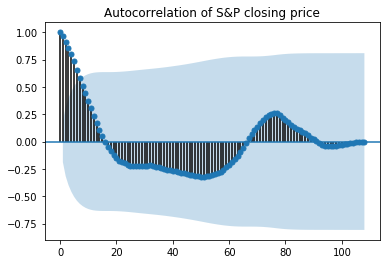

In [161]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
acf_plot=plot_acf(y_train,title='Autocorrelation of S&P closing price')

By looking at the autocorrelation function (ACF) plot of the series, we can tentatively identify the autocorelation in the series. ACF is a bar chart of the coefficients of correlation between a time series and lags of itself. Let us reduce the lags to 25 to get a clear picture of the graph.

#### PACF Plot - Partial AutoCorelation Plot

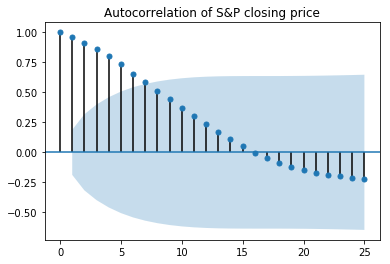

In [162]:
acf_plot=plot_acf(y_train,title='Autocorrelation of S&P closing price',lags=25)

so here from above graph we can observe that approximately 7 lags are outside the blue curve which means inorder to explain this regression equation accurately we need to have 7 lag terms. however there is a catch, what if the second lag(lag-2) is a function of first lag (lag-1) or third lag(lag-3) is a function of (lag-2)? Lets resolve this using PACF plot.

Refernce :- https://people.duke.edu/~rnau/411arim3.htm

#### PACF_plot - Partial Autocorelation Function plot

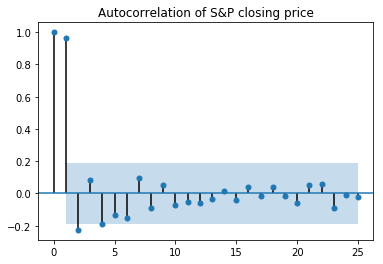

In [164]:
pacf_plot=plot_pacf(y_train,title='Autocorrelation of S&P closing price',lags=25)

Above graph provides a very intresting view of the lags so here we have eliminated the effect of previous lags by using the PACF or partial Autocorelation function we get to know that almost 3 lags are outside the blue shaded region (95% confidence level) which means these lags are to be included in our model they are (lag-1, lag-2, lag-3(which is negative) and then lag-5(again negative).

hence the order of the autoregression model would be 4 or 5 depending on the confidence level.


Reference :- https://people.duke.edu/~rnau/411arim3.htm